# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

### Gather observables

In [6]:
def f_gather_data(fname):
    
    # Get Plaquette values
    cmd="grep 'Plaq' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr1=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), 
      np.float64(i.split(' ')[-1]),
      np.float64(i.split(': ')[2].split(' s')[0])] 
     for i in op])
    
    # Gather Polykov loop values
    cmd="grep 'Polyakov' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr2=np.array([complex(np.float64(i.split(' ')[-1][1:-1].split(',')[0]),
             np.float64(i.split(' ')[-1][1:-1].split(',')[1])) 
     for i in op ])
    
    ## Total time
    cmd="grep 'Total time for trajectory' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr3=[np.float32(i.split(': ')[-1]) for i in op]
    
    
    lgth=min(len(arr1),len(arr2),len(arr3))
#     print(lgth)

    ## Metropolis values
    cmd="grep 'Metropolis_test' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
    skip=lgth-len(arr_temp)
#     print("skip",skip)
    arr_skip=[np.nan for i in range(skip)]
    arr4=np.array(arr_skip+arr_temp)

    
    ## Create dataframe
    cols=['iter','Plaquette','Polyakov','Traj_time','Accept','Plaq_epoch']
    df=pd.DataFrame(columns=cols)

    df['Plaquette']=arr1[:,1]
    df['Plaq_epoch']=arr1[:,2]
    df['iter']=arr1[:,0].astype(int)
    df['Polyakov']=arr2
    df['Traj_time']=arr3
    df['Accept']=arr4

    return df


def f_get_summary(df):
    drop_idx=20

    y=df.Plaquette.values[drop_idx:]
    plaq=gv.dataset.avg_data(y)

    y=np.abs(df.Polyakov.values[drop_idx:])
    polyakov=gv.dataset.avg_data(y)

    y=df.Traj_time.values[drop_idx:]
    traj_time=gv.dataset.avg_data(y)
    
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    return plaq, polyakov, accpt, traj_time


In [7]:
dict_list=[]

df_combined=pd.DataFrame([])
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'

flist=[]
for fldr in glob.glob(top_dir+'run_L*'): 
    fname=fldr+'/HSDM.out'
    
    if not os.path.isfile(fname): continue
        
    flist.append(fname)
    
    
    try: 
        df=f_gather_data(fname)
        beta = float(fname.split('/')[-2].split('_')[-2].split('-')[-1])
        mf   = float(fname.split('/')[-2].split('_')[-1].split('-')[-1])
        dict1={'beta':beta, 'mf':mf, 'df':df}
    #     print(dict1)
    
        dict_list.append(dict1)
        # Get summary data
        plaq,polyakov,accpt,traj_time=f_get_summary(df)
        dict1={'beta':beta, 'mf':mf, 'plaq':plaq,'polyakov':polyakov,'acceptance':accpt, 'traj_time':traj_time}

        df_summary=pd.concat([df_summary,pd.DataFrame(dict1,index=[df_summary.shape[0]+1])])    
    
    except Exception as e: 
        print(fname)
        print(e)
    

df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)

In [8]:
df_summary

,beta,mf,plaq,polyakov,acceptance,traj_time
0,8.00,0.6443,0.289102(38),0.00333(12),98.50000,14.7151(25)
1,9.00,0.4443,0.3452(12),0.00390(37),97.00000,15.8405(23)
2,9.00,0.6443,0.3450(12),0.00401(36),98.00000,14.5229(43)
3,9.00,0.8443,0.3448(12),0.00396(36),98.50000,13.8695(25)
4,10.00,0.6443,0.4287(13),0.00495(56),93.50000,14.5397(30)
5,10.25,0.6443,0.4717(12),0.00525(63),93.50000,14.5515(38)
6,10.50,0.4443,0.53990(55),0.00710(72),96.00000,15.9718(22)
7,10.50,0.6443,0.53512(10),0.00471(24),97.00000,14.4456(26)
8,10.50,0.8443,0.53234(18),0.00487(27),94.83871,13.7103(17)
9,10.75,0.6443,0.56210(46),0.01352(83),98.00000,14.2611(24)


## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [9]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))

<IPython.core.display.Javascript object>


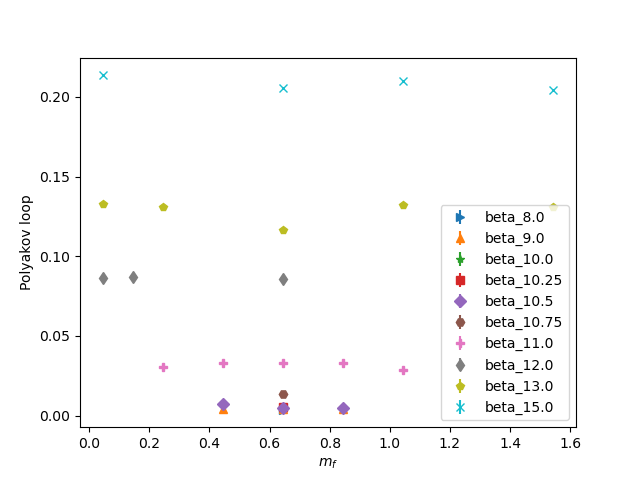

Text(0, 0.5, 'Polyakov loop')

In [10]:
plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


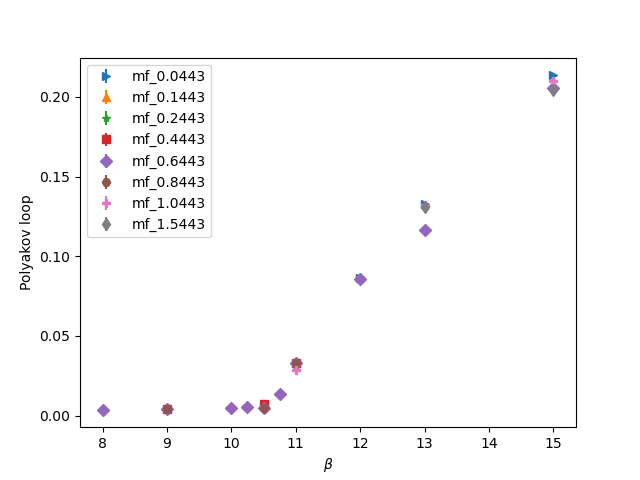

Text(0, 0.5, 'Polyakov loop')

In [11]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_beta.pdf')

## Individual plots

<IPython.core.display.Javascript object>


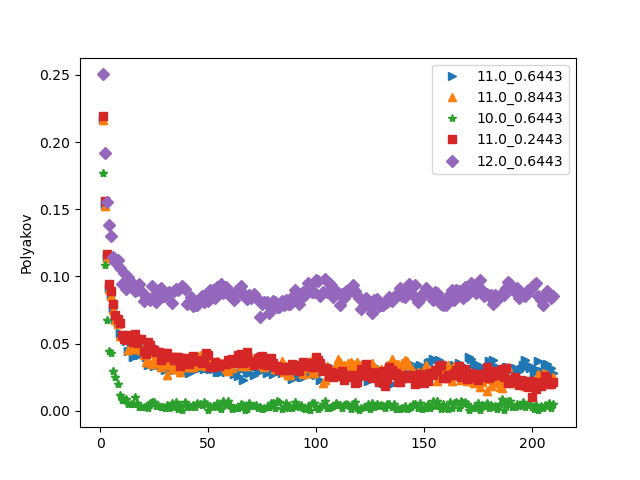

11.0_0.6443
11.0_0.8443
10.0_0.6443
11.0_0.2443
12.0_0.6443


In [43]:

def f_plot_specific_runs(df,column,beta_list,mf_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    ## Gather list elements with given beta values
    short_list=[i for i in dict_list if i['beta'] in beta_list]
    ## Gather mf
    short_list=[i for i in short_list if i['mf'] in mf_list]
    
    assert len(short_list)>0 ,"Shortened list has 0 elements" 
        
    
    plt.figure()

    for i,marker in zip(short_list,itertools.cycle('>^*sDHPdpx_')):

        df=i['df']
        label=str(i['beta'])+'_'+str(i['mf'])
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.show()
    
    
beta_list=[10.0,11.0,12.0]
mf_list=[0.2443,0.6443,0.8443]
# f_plot_specific_runs(df,'Plaquette',beta_list,mf_list)
# f_plot_specific_runs(df,'Traj_time',beta_list,mf_list)
f_plot_specific_runs(df,'Polyakov',beta_list,mf_list)

### Plot Polyakov loop

In [ ]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


<IPython.core.display.Javascript object>


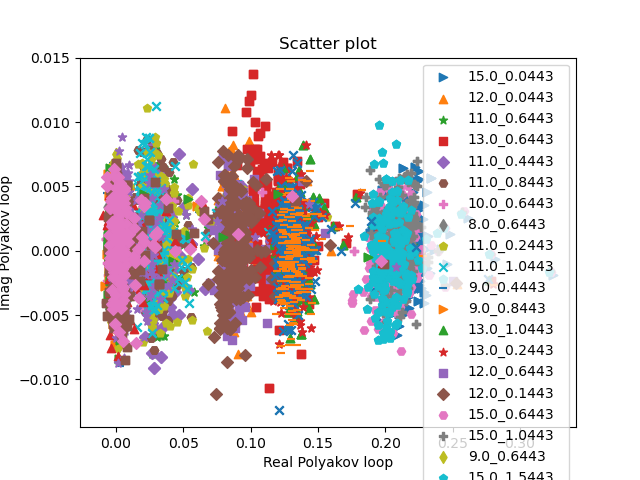

15.0_0.0443
12.0_0.0443
11.0_0.6443
13.0_0.6443
11.0_0.4443
11.0_0.8443
10.0_0.6443
8.0_0.6443
11.0_0.2443
11.0_1.0443
9.0_0.4443
9.0_0.8443
13.0_1.0443
13.0_0.2443
12.0_0.6443
12.0_0.1443
15.0_0.6443
15.0_1.0443
9.0_0.6443
15.0_1.5443
13.0_1.5443
13.0_0.0443
10.25_0.6443
10.5_0.6443
10.75_0.6443
10.5_0.4443
10.5_0.8443


In [45]:
fig=plt.figure()

for i,marker in zip(dict_list,itertools.cycle('>^*sDHPdpx_')):
    df=i['df']
    label=str(i['beta'])+'_'+str(i['mf'])
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [40]:
# 1.0/(2*(m+4))
1.0/(2*0.12) - 4 

0.16666666666666696